<h1><center>Generative Adversarial Networks</center></h1>

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




Определим нужное нам устройство:

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### 1. Загрузка датасета

In [3]:
img_size = 2 # размер данных которую мы будет подавать в нейронные сети
batch_size = 9 # размер батча
img_shape = (img_size,) # полный шейп 

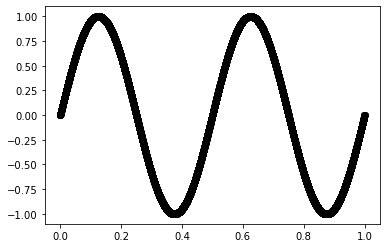

In [4]:
from matplotlib import pyplot as plt
x = np.arange(0,4*np.pi,0.001)   # start,stop,step

y_sin = np.sin(x)
x=x/x.max()


plt.scatter(x, y_sin, color='k')
plt.show()

In [5]:
x.shape

(12567,)

In [6]:
class customDataset(Dataset):
    # Здесь мы определяем наши данные. Обычно картинки и метки.
    def __init__(self, x):
        
        self.x = x
        
        
    # Так же нужно переопределить метод __len__
    def __len__(self):
        return len(self.x)
    
    # И этот метод в который будет возвращать нам один сэмпл наших данных
    def __getitem__(self, idx):
        """Здесь производим необходимые преобразования над нашими данными"""
        return self.x[idx]

In [7]:
import pandas as pd
np_df_sin=np.zeros([len(x),2])
np_df_sin[:,0] = x
np_df_sin[:,1] = y_sin





df_train = pd.DataFrame(data=np_df_sin, columns=["x", "y"])
df_train = df_train.reset_index()

X = df_train[['x', 'y']]
X = X[:12500]
X.shape

(12500, 2)

In [8]:
train_ds = customDataset(X.values)

In [9]:
batch_size = 500
real_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


### 2. Создание модели

#### 2.1 Генератор:


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128), # Звездочка означает unpacking списка
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256, 0.8),
#            nn.Linear(256, 512),
#            nn.LeakyReLU(0.2, inplace=True),
#            nn.BatchNorm1d(512, 0.8),
#            nn.Linear(512, 1024),
#            nn.ReLU(0.2),
#            nn.BatchNorm1d(1024, 0.8),
#            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Linear(256, int(np.prod(img_shape))),            
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


#### 2.2 Дискриминатор:



In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
                        

        return validity

# 3. Обучение

Инициализация:

In [12]:
n_epochs = 1000 # количество эпох
lr = 0.01 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 2 # Размерность случайного вектора, который подается на вход генератору

sample_interval = 100 

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [14]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

[Epoch 0/1000] [Batch 0/25] [D loss: 0.706076] [G loss: 0.774515]
[Epoch 4/1000] [Batch 0/25] [D loss: 0.788130] [G loss: 0.573031]
[Epoch 8/1000] [Batch 0/25] [D loss: 0.739081] [G loss: 0.641954]
[Epoch 12/1000] [Batch 0/25] [D loss: 0.592928] [G loss: 1.180823]
[Epoch 16/1000] [Batch 0/25] [D loss: 0.618305] [G loss: 0.768702]
[Epoch 20/1000] [Batch 0/25] [D loss: 0.651456] [G loss: 0.983756]
[Epoch 24/1000] [Batch 0/25] [D loss: 0.649504] [G loss: 0.814147]
[Epoch 28/1000] [Batch 0/25] [D loss: 0.610102] [G loss: 0.886767]
[Epoch 32/1000] [Batch 0/25] [D loss: 0.525876] [G loss: 1.169181]
[Epoch 36/1000] [Batch 0/25] [D loss: 0.680078] [G loss: 0.687903]
[Epoch 40/1000] [Batch 0/25] [D loss: 0.544630] [G loss: 0.990874]
[Epoch 44/1000] [Batch 0/25] [D loss: 0.472812] [G loss: 1.126937]
[Epoch 48/1000] [Batch 0/25] [D loss: 0.576964] [G loss: 0.952503]
[Epoch 52/1000] [Batch 0/25] [D loss: 0.620046] [G loss: 0.965872]
[Epoch 56/1000] [Batch 0/25] [D loss: 0.568079] [G loss: 1.315929

[Epoch 484/1000] [Batch 0/25] [D loss: 0.359663] [G loss: 1.108917]
[Epoch 488/1000] [Batch 0/25] [D loss: 0.325955] [G loss: 1.348862]
[Epoch 492/1000] [Batch 0/25] [D loss: 0.271983] [G loss: 2.252085]
[Epoch 496/1000] [Batch 0/25] [D loss: 0.436717] [G loss: 1.620371]
[Epoch 500/1000] [Batch 0/25] [D loss: 0.336803] [G loss: 1.761478]
[Epoch 504/1000] [Batch 0/25] [D loss: 0.390047] [G loss: 2.405615]
[Epoch 508/1000] [Batch 0/25] [D loss: 0.353025] [G loss: 1.953383]
[Epoch 512/1000] [Batch 0/25] [D loss: 0.375469] [G loss: 1.445649]
[Epoch 516/1000] [Batch 0/25] [D loss: 0.366929] [G loss: 1.521910]
[Epoch 520/1000] [Batch 0/25] [D loss: 0.341255] [G loss: 2.218365]
[Epoch 524/1000] [Batch 0/25] [D loss: 0.400015] [G loss: 1.520866]
[Epoch 528/1000] [Batch 0/25] [D loss: 0.503671] [G loss: 0.912343]
[Epoch 532/1000] [Batch 0/25] [D loss: 0.418859] [G loss: 1.500898]
[Epoch 536/1000] [Batch 0/25] [D loss: 0.485840] [G loss: 1.014156]
[Epoch 540/1000] [Batch 0/25] [D loss: 0.390861]

[Epoch 968/1000] [Batch 0/25] [D loss: 0.359584] [G loss: 1.698769]
[Epoch 972/1000] [Batch 0/25] [D loss: 0.368348] [G loss: 1.693351]
[Epoch 976/1000] [Batch 0/25] [D loss: 0.348964] [G loss: 1.729284]
[Epoch 980/1000] [Batch 0/25] [D loss: 0.362770] [G loss: 1.996099]
[Epoch 984/1000] [Batch 0/25] [D loss: 0.358796] [G loss: 1.638315]
[Epoch 988/1000] [Batch 0/25] [D loss: 0.298129] [G loss: 1.791991]
[Epoch 992/1000] [Batch 0/25] [D loss: 0.208267] [G loss: 2.304340]
[Epoch 996/1000] [Batch 0/25] [D loss: 0.343163] [G loss: 1.822158]


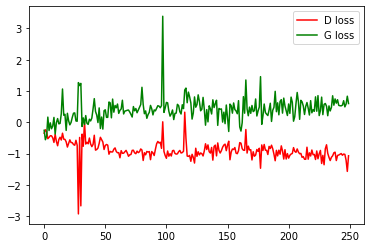

In [15]:
for epoch in range(n_epochs):
    for i, (imgs) in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
 




        if batches_done % sample_interval == 0:
            with torch.no_grad():
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                
plt.clf()

plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
plt.legend()
plt.show()

                
            

In [16]:
torch.save(generator.state_dict(), "vanilla_gan.pth")

In [17]:
z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
z

tensor([[-6.1026e-01,  2.6511e-01],
        [ 2.8726e-01, -4.3795e-01],
        [ 3.8152e-01, -1.6750e+00],
        [-8.6365e-02, -1.1079e+00],
        [ 7.0529e-01,  1.8804e+00],
        [-1.2590e+00,  3.8374e-01],
        [-5.9198e-01,  2.3730e+00],
        [-4.2567e-01,  1.3872e-01],
        [-5.3419e-01,  1.5332e+00],
        [ 4.9940e-01, -1.8301e-01],
        [ 5.7700e-01, -9.5500e-01],
        [ 2.2477e-01,  5.4414e-01],
        [ 1.3162e+00,  1.9105e-01],
        [-2.4753e-01, -1.2110e+00],
        [ 1.7014e+00, -1.8360e+00],
        [-2.4372e+00,  6.0594e-02],
        [-1.1612e+00,  1.6578e+00],
        [-6.5647e-01,  4.2640e-01],
        [-2.1375e-01,  8.2825e-01],
        [ 5.8093e-01,  8.7023e-01],
        [ 8.1396e-01,  1.2072e+00],
        [ 1.3601e+00,  1.1499e+00],
        [ 1.9428e+00,  6.9170e-01],
        [-1.1418e+00,  9.8319e-01],
        [-5.8951e-01, -1.0841e+00],
        [-1.3414e-02, -7.9600e-02],
        [ 6.8586e-01, -7.9259e-01],
        [-8.0895e-01, -5.567

In [18]:
# Генерируем даные Генератором на основе шума
gen_imgs = generator(z)
gen_imgs

tensor([[ 0.8540, -0.9759],
        [ 0.7283,  0.1564],
        [ 0.6350,  0.9724],
        [ 0.7289,  0.1460],
        [ 0.8207, -0.8437],
        [ 0.8963, -0.9673],
        [ 0.9160, -0.8495],
        [ 0.8346, -0.9235],
        [ 0.8919, -0.9705],
        [ 0.7190,  0.2673],
        [ 0.6575,  0.9139],
        [ 0.7963, -0.6675],
        [ 0.6436,  0.9524],
        [ 0.7419, -0.0211],
        [ 0.6506,  0.9983],
        [ 0.9412, -0.7417],
        [ 0.9247, -0.8218],
        [ 0.8634, -0.9871],
        [ 0.8476, -0.9647],
        [ 0.7782, -0.4788],
        [ 0.7733, -0.4166],
        [ 0.7027,  0.4493],
        [ 0.6349,  0.9854],
        [ 0.9064, -0.9324],
        [ 0.7880, -0.5927],
        [ 0.7856, -0.5649],
        [ 0.6551,  0.9227],
        [ 0.8347, -0.9225],
        [ 0.6375,  0.9936],
        [ 0.7208,  0.2431],
        [ 0.8172, -0.8226],
        [ 0.7942, -0.6502],
        [ 0.8414, -0.9491],
        [ 0.6818,  0.7292],
        [ 0.8902, -0.9779],
        [ 0.6736,  0

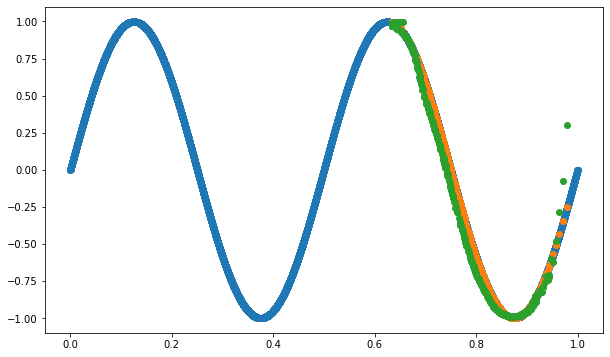

In [21]:
gen_imgs = gen_imgs.cpu().detach()

real_y = np.sin(gen_imgs[:,0]*4*np.pi)

fig= plt.figure(figsize=(10,6))
plt.scatter(x, y_sin)
plt.scatter(gen_imgs[:,0], real_y)
plt.scatter(gen_imgs[:,0], gen_imgs[:,1])

plt.show()

In [22]:
min(gen_imgs[:,0]), max(gen_imgs[:,0])

(tensor(0.6339), tensor(0.9796))

### P.S. Почему нижний предел был равен 0.6339 а не 0. - осталось загадкой...